In [1]:
# In[111]:
import os
import sys
import operator
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.decomposition import PCA
from Part2_get_data import get_data
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from collections import OrderedDict
from multiprocessing import Process, Lock, Manager
from sklearn.metrics import classification_report


In [2]:
# ### Get data : Call a function 'get_data' that is defined in the script 'Part2_get_data'. It will create the directories if not already created, download the zip files and unzip them.

# In[ ]:
global quarter
global nextQuarter

In [3]:
# Load data into DataFrame
def load_data_df(quarter, nextQuarter):
    global df1
    global df2
    col_names_svcg = ['loan_sequence_no', 'monthly_reporting_period', 'current_actual_upb', 'current_loan_delinquency_status',
                      'loan_age', 'remaning_months_on_legal_maturity', 'repurchase_flag', 'modification_flag', 'zero_bal_code',
                      'zero_bal_eff_date', 'current_interest_rate', 'current_deferred_upb', 'ddlpi', 'mi_recoveries', 'net_sales_proceeds',
                      'non_mi_recoveries', 'expenses', 'legal_costs', 'maintenance_preservation_cost', 'taxes_insurance', 'misc_expenses',
                      'actual_loss_calc', 'modification_cost']

    df1 = pd.read_table(os.path.join('part2_data_downloaded_zips_unzipped/historical_data1_time_' + quarter + ".txt"),
                        delimiter='|', names=col_names_svcg, low_memory=False, index_col=None, nrows=200000, usecols=list(np.arange(23)))
    df2 = pd.read_table(os.path.join('part2_data_downloaded_zips_unzipped/historical_data1_time_' + nextQuarter + ".txt"),
                        delimiter='|', names=col_names_svcg, low_memory=False, index_col=None, nrows=200000, usecols=list(np.arange(23)))


In [4]:
# ### Data Preprocessing
# Handle Null values
#
# Change Categorical value type to category (equivalent to factors in R)
def remove_nan(dff):
    dff.current_loan_delinquency_status = dff.current_loan_delinquency_status.replace('R', '1').astype('float64')

    dff.remaning_months_on_legal_maturity = dff.remaning_months_on_legal_maturity.replace(np.nan, 0)
    dff.remaning_months_on_legal_maturity = dff.remaning_months_on_legal_maturity.astype('category')

    dff.repurchase_flag = dff.repurchase_flag.replace(np.nan, 0)
    dff.repurchase_flag = dff.repurchase_flag.astype('category')

    dff.modification_flag = dff.modification_flag.replace(np.nan, 0)
    dff.modification_flag = dff.modification_flag.astype('category')

    dff.zero_bal_code = dff.zero_bal_code.replace(np.nan, 0)
    dff.zero_bal_code = dff.zero_bal_code.astype('category')

    dff.zero_bal_eff_date = dff.zero_bal_eff_date.replace(np.nan, 0)
    dff.zero_bal_eff_date = dff.zero_bal_eff_date.astype('category')

    dff.current_deferred_upb = dff.current_deferred_upb.replace(np.nan, 0)
    dff.current_deferred_upb = dff.current_deferred_upb.astype('category')

    dff.ddlpi = dff.ddlpi.replace(np.nan, 0)
    dff.ddlpi = dff.ddlpi.astype('category')

    dff.mi_recoveries = dff.mi_recoveries.replace(np.nan, 0)

    dff.net_sales_proceeds = dff.net_sales_proceeds.replace(np.nan, 0)
    dff.net_sales_proceeds = dff.net_sales_proceeds.replace('C', 1)
    dff.net_sales_proceeds = dff.net_sales_proceeds.replace('U', 0)
    dff.net_sales_proceeds.astype('float64')

    dff.non_mi_recoveries = dff.non_mi_recoveries.replace(np.nan, 0)

    dff.expenses = dff.expenses.replace(np.nan, 0)

    dff.legal_costs = dff.legal_costs.replace(np.nan, 0)

    dff.maintenance_preservation_cost = dff.maintenance_preservation_cost.replace(np.nan, 0)
    dff.taxes_insurance = dff.taxes_insurance.replace(np.nan, 0)
    dff.misc_expenses = dff.misc_expenses.replace(np.nan, 0)
    dff.actual_loss_calc = dff.actual_loss_calc.replace(np.nan, 0)
    dff.modification_cost = dff.modification_cost.replace(np.nan, 0)

In [5]:
# #### Processing the data, Change the numerical features to Dummy variables, Create the target variable,  Create Training and Testing datasets
def process_data():
    # Create target variable function
    def f(row):
        if row['current_loan_delinquency_status'] > 0:
            val = 1
        else:
            val = 0
        return val
    # Create dummy variables
    df1_dummies = pd.get_dummies(df1[['repurchase_flag', 'modification_flag']])
    df2_dummies = pd.get_dummies(df2[['repurchase_flag', 'modification_flag']])

    df1_d = df1.drop(['loan_sequence_no', 'repurchase_flag', 'modification_flag'], axis=1)
    df2_d = df2.drop(['loan_sequence_no', 'repurchase_flag', 'modification_flag'], axis=1)

    global df1_final
    global df2_final
    df1_final = pd.concat([df1_d, df1_dummies], axis=1)
    df2_final = pd.concat([df2_d, df2_dummies], axis=1)

    # create target variable
    df1_final['Deliquent'] = df1_final.apply(f, axis=1)
    df2_final['Deliquent'] = df2_final.apply(f, axis=1)

    # Create training and testing set

    X_train = df1_final.drop(['current_loan_delinquency_status', 'Deliquent'], axis=1)
    y_train = df1_final['Deliquent']

    X_test = df2_final.drop(['current_loan_delinquency_status', 'Deliquent'], axis=1)
    y_test = df2_final['Deliquent']

    X_train = preprocessing.minmax_scale(np.array(X_train).astype(float))  # scale between 0 and 1
    X_test = preprocessing.minmax_scale(np.array(X_test).astype(float))

    return X_train, y_train, X_test, y_test

In [6]:
# ## Models:
# ### Logistic Regression

# In[78]:

# Logistic Regression
#X_train = preprocessing.scale(X_train, with_mean=True)
#X_test = preprocessing.scale(X_test, with_mean=True)


def logred(X_train, y_train, X_test, y_test, return_dict_logred):

    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)

    y_train_predicted = logreg.predict(X_train)
    y_test_predicted = logreg.predict(X_test)

    #print(metrics.classification_report(y_train, y_train_predicted))

    conf_mat_logred = metrics.confusion_matrix(y_test, y_test_predicted)
    print(conf_mat_logred)

    # Compute ROC curve and AUC (Area under the Curve)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)

    roc_auc_logred = metrics.auc(false_positive_rate, true_positive_rate)
    return_dict_logred['roc_auc_logred'] = roc_auc_logred
    return_dict_logred['conf_mat_logred'] = conf_mat_logred

    # Plot ROC Curve
    plt.title("Logistic Regression")
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = %0.2f' % roc_auc_logred)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [7]:
# ### Random Forest

# In[91]:

# random Forest
def rf(X_train, y_train, X_test, y_test, return_dict_rf):
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)

    y_train_predicted = rf.predict(X_train)
    y_test_predicted = rf.predict(X_test)

    conf_mat_rf = metrics.confusion_matrix(y_test, y_test_predicted)
    print(conf_mat_rf)

    # Compute ROC curve and AUC (Area under the Curve
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)

    roc_auc_rf = metrics.auc(false_positive_rate, true_positive_rate)
    return_dict_rf['roc_auc_rf'] = roc_auc_rf
    return_dict_rf['conf_mat_rf'] = conf_mat_rf

    # Plot ROC Curve
    plt.title("Random Forest")
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = %0.2f' % roc_auc_rf)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [8]:
# ### Neural Network

def nn(X_train, y_train, X_test, y_test, return_dict_nn):

    nn = MLPClassifier()

    nn.fit(X_train, y_train)

    y_train_predicted = nn.predict(X_train)
    y_test_predicted = nn.predict(X_test)

    conf_mat_nn = metrics.confusion_matrix(y_test, y_test_predicted)
    print(conf_mat_nn)

    # Compute ROC curve and AUC (Area under the Curve
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)

    roc_auc_nn = metrics.auc(false_positive_rate, true_positive_rate)
    return_dict_nn['roc_auc_nn'] = roc_auc_nn
    return_dict_nn['conf_mat_nn'] = conf_mat_nn

    # Plot ROC Curve
    plt.title("Neural Network")
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = %0.2f' % roc_auc_nn)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [9]:

# ### Support Vector Machine (SVM)

# In[ ]:

def svm():
    from sklearn.svm import SVC

    clf = SVC()
    clf.fit(X_train, y_train)

    #y_train_predicted = clf.predict(X_train)
    y_test_predicted = clf.predict(X_test)

    global conf_mat_svm
    conf_mat_svm = metrics.confusion_matrix(y_test, y_test_predicted)
    print(conf_mat_svm)

    # Compute ROC curve and AUC (Area under the Curve
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)
    global roc_auc_svm
    roc_auc_svm = metrics.auc(false_positive_rate, true_positive_rate)

    # Plot ROC Curve
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = %0.2f' % roc_auc_svm)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [10]:
def genMatrix(quarter, roc_auc_logred, roc_auc_rf, roc_auc_nn, conf_mat_logred, conf_mat_rf, conf_mat_nn, matrix):
    all_auc = {'logred': roc_auc_logred, 'rf': roc_auc_rf, 'nn': roc_auc_nn}
    model = max(all_auc.items(), key=operator.itemgetter(1))[0]
    all_conf = {'logred': conf_mat_logred, 'rf': conf_mat_rf, 'nn': conf_mat_nn}
    all_conf_array = all_conf[model]
    No_of_actual_delq = all_conf_array[1][0] + all_conf_array[1][1]
    No_of_pred_delq = all_conf_array[0][1] + all_conf_array[1][1]
    No_of_records = all_conf_array[0][1] + all_conf_array[1][1] + all_conf_array[1][0] + all_conf_array[0][0]
    No_of_delq_properly_classified = all_conf_array[1][1]
    No_of_nonDelq_improperly_classified_as_delq = all_conf_array[0][1]

    # In[131]:

    all_conf_df = pd.DataFrame(OrderedDict((('Quarter', [quarter]),
                                            ('No_of_actual_delq', [No_of_actual_delq]),
                                            ('No_of_pred_delq', [No_of_pred_delq]),
                                            ('No_of_records', [No_of_records]),
                                            ('No_of_delq_properly_classified', [No_of_delq_properly_classified]),
                                            ('No_of_nonDelq_improperly_classified_as_delq', [No_of_nonDelq_improperly_classified_as_delq]))))

    matrix = pd.concat([all_conf_df, matrix], axis=0)
    return matrix


In [11]:
def get_next_quarter(QUARTER):
    quarterNumber = int(QUARTER[1])
    quarterYear = int(QUARTER[2:6])

    if quarterNumber < 4:
        newQuarterNumber = quarterNumber + 1
        newQuarterYear = quarterYear
    else:
        newQuarterNumber = quarterNumber - 3
        newQuarterYear = quarterYear + 1

    QUARTER2 = "Q" + str(newQuarterNumber) + str(newQuarterYear)

    return QUARTER2

In [13]:
global X_train
global y_train
global X_test
global y_test
global matrix
global conf_mat_logred
global conf_mat_rf
global conf_mat_nn
global roc_auc_logred
global roc_auc_rf
global roc_auc_nn
manager = Manager()
return_dict_logred = manager.dict()
return_dict_rf = manager.dict()
return_dict_nn = manager.dict()
matrix = pd.DataFrame(OrderedDict((('Quarter', []),
                                   ('No_of_actual_delq', []),
                                   ('No_of_pred_delq', []),
                                   ('No_of_records', []),
                                   ('No_of_delq_properly_classified', []),
                                   ('No_of_nonDelq_improperly_classified_as_delq', []))))

In [17]:
quarters = []
end = ''
startQuarter = 'Q12005'
endQuarter = 'Q22005'
end = endQuarter

while(startQuarter != endQuarter):
    print(startQuarter)
    quarters.append(startQuarter)
    startQuarter = get_next_quarter(startQuarter)
quarters.append(endQuarter)

downloadQuarters = quarters[:]
# downloadQuarters.append(get_next_quarter(end))
print(downloadQuarters)
print(quarters)


Q12005
['Q12005', 'Q22005']
['Q12005', 'Q22005']


Q12005
Q22005
process data executed


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[[191498      2]
 [  8239    261]]


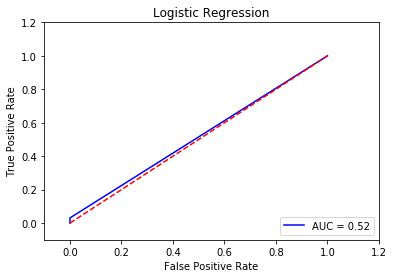

[[188480   3020]
 [  7759    741]]


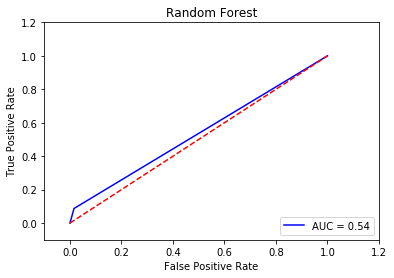

[[191498      2]
 [  8239    261]]


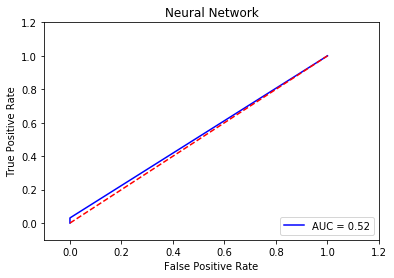

  Quarter  No_of_actual_delq  No_of_pred_delq  No_of_records  \
0  Q12005             8500.0           3761.0       200000.0   
0  Q12005             8500.0           3761.0       200000.0   

   No_of_delq_properly_classified  No_of_nonDelq_improperly_classified_as_delq  
0                           741.0                                       3020.0  
0                           741.0                                       3020.0  


In [25]:
# for q in quarters:
q = 'Q12005'
# nextQuarter = get_next_quarter(q)
nextQuarter = 'Q22005'
print(q)
print(nextQuarter)
load_data_df(q, nextQuarter)
remove_nan(df1)
remove_nan(df2)
X_train, y_train, X_test, y_test = process_data()
print("process data executed")

p1 = Process(target=logred,args=(X_train, y_train,X_test,y_test,return_dict_logred))
p2 = Process(target=rf,args=(X_train, y_train,X_test,y_test,return_dict_rf))
p3 = Process(target=nn,args=(X_train, y_train,X_test,y_test,return_dict_nn))
p1.start()
p2.start()
p3.start()
p1.join()
p2.join()
p3.join()
matrix=genMatrix(q,return_dict_logred['roc_auc_logred'],return_dict_rf['roc_auc_rf'],return_dict_nn['roc_auc_nn'],return_dict_logred['conf_mat_logred'],return_dict_rf['conf_mat_rf'],return_dict_nn['conf_mat_nn'],matrix)

print(matrix)
matrix.to_csv('matrix_classification.csv')